<div style="background: #DDE2FF;
            font-family: Bookerly;
            font-size: 16px; 
            font-weight: 100;
            padding: 20px 5px 0px 5px; 
            border: 10px solid #DDE2FF; 
            margin-left: 1px;
            margin-right: 1px;"
          
 <font color='blue'>**Chapter 31-2: Solving PDEs Using Differential Quadrature**. 

Differential quadrature is the approximation of derivatives by using weighted sums of function values. Differential quadrature is of practical interest because its allows one to compute derivatives from noisy data. The name is in analogy with quadrature, meaning numerical integration, where weighted sums are used in methods such as Simpson's method or the Trapezoidal rule. There are various methods for determining the weight coefficients, for example, the Savitzky–Golay filter. Differential quadrature is used to solve partial differential equations. There are further methods for computing derivatives from noisy data.
 

<br>

  </font>
  
  
  
</div>

<div style="background: #FFE3CC;
            font-family: Bookerly;
            font-size: 16px; 
            font-weight: 100;
            padding: 15px 5px 10px 5px;
            border: 10px solid #FFE3CC;  
            margin-left: 1px;
            margin-right: 1px;"
     
<font color='blue'>1.3. Solve the one-dimensional Burgers' equation,

$$\frac{\partial u}{\partial t}\,-\,\nu\frac{\partial^2 u}{\partial x^2}\,+\,u\frac{\partial u}{\partial x}\,=\,0$$

while observing a boundary condition of 

$$u(x,0)\,=\,f(x)\:\:\:\textrm{in}\:\:\:\Omega$$

and initial condition of

$$u(x,t)\,=\,0\:\:\:\textrm{on}\:\:\:\partial \Omega\:\scriptsize{\times}\:(0,T]$$


</font>
</div>

In [1]:
'''
    Numerical Solution of Burger's Equation based on Differential Quadrature method.
    Reference Paper - https://onlinelibrary.wiley.com/doi/10.1002/num.22178
    Solution taken from the Github repository of mn619.
'''

"\n    Numerical Solution of Burger's Equation based on Differential Quadrature method.\n    Reference Paper - https://onlinelibrary.wiley.com/doi/10.1002/num.22178\n"

In [2]:
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [3]:
N, M = 30, 30  #Mesh Size
iteration = 5 #Number of times to iterate for finding numerical solution
mu = 0.1
pi = np.pi

In [4]:
'''
    Setting up everything as global variables
'''

x = [(1-np.cos(pi*(i - 1)/(M - 1)))*0.5 for i in range(M + 1)]
t = [(1-np.cos(pi*(i - 1)/(N - 1)))*0.5 for i in range(N + 1)]

A_init = np.zeros((N + 1, N + 1))
B_init = [np.zeros((M + 1, M + 1)) for i in range(3)]
A = np.zeros((N - 1, N - 1))
B = [np.zeros((M - 2, M - 2)) for i in range(3)]
alpha = [np.zeros((N - 1, M - 2)) for i in range(iteration + 1)]
beta = np.zeros((M - 2, M - 2))
F = [np.zeros((N - 1, M - 2)) for i in range(iteration + 1)]
U_init = [np.zeros((N + 1, M + 1)) for i in range(iteration + 1)]
U = [np.zeros((N - 1, M - 2)) for i in range(iteration + 1)] 
beta_k = np.zeros(((N - 1)*(M - 2), (N - 1)*(M - 2)))

In [5]:
'''
    All the functions required to initialize the variables
'''

def f(x):
        return np.sin(np.pi*x)

def cal_coef(n, mu):
    ans = 0
    for i in range(0, 1000):
        x = (2*i + 1)/2000
        ans += math.exp(-(1-np.cos(np.pi*x))/(2*np.pi*mu))*np.cos(n*np.pi*x)*1/1000
    if(n == 0):
        return ans
    else:
        return 2*ans
    
def cal_A(n, m):
    ans = 1
    if(n != m):
        for l in range(1, M + 1):
            if(l != n and l != m):
                ans *= (x[n] - x[l])/(x[m] - x[l])
        ans *= 1/(x[m] - x[n])
    else:
        ans = 0
        for l in range(1, M + 1):
            if(l != n):
                ans += 1/(x[n] - x[l])
    return ans

def cal_B(n, m):
    ans = 1
    if(n != m):
        for l in range(1, N + 1):
            if(l != n and l != m):
                ans *= (t[n] - t[l])/(t[m] - t[l])
        ans *= 1/(t[m] - t[n])
    else:
        ans = 0
        for l in range(1, N + 1):
            if(l != m):
                ans += 1/(t[m] - t[l])
    return ans

def cal_alpha(n, m, k):
    ans = 0
    for j in range(1, M + 1):
        ans += B_init[1][m + 2,j]*U_init[k][n + 2, j]
    return ans

def cal_F(n, m, k):
    return U_init[k][n + 2, m + 2]*alpha[k][n,m] - A_init[n + 2][1]*f(x[m + 2])

def vec(X):
    assert(X.shape == (N - 1, M - 2))
    temp = X.flatten('F')
    return temp.reshape(-1, 1)

def diag(X):
    assert(len(X) == (N - 1)*(M - 2))
    return np.diagflat(X)

In [6]:
'''
    Initialising all the variables
'''
#Calculate U_init[0]
for j in range(1, M + 1):
    U_init[0][1,j] = f(x[j])

#Calculate A_init
for i in range(1, N + 1):
    for j in range(1, N + 1):
        A_init[i,j] = cal_A(i,j)
        
#Calculate B_init[1]
for i in range(1, M + 1):
    for j in range(1, M + 1):
        B_init[1][i,j] = cal_B(i,j)

#Calculate B_init[2]
for i in range(1, M + 1):
    for j in range(1, M + 1):
        if( i != j):
            B_init[2][i,j] = 2*(B_init[1][i,j]*B_init[1][i,i] - B_init[1][i,j]/(t[i] - t[j]))
    for j in range(1, N + 1):
        if(j != i):
            B_init[2][i,i] -= B_init[2][i,j]

#Calculate A
for i in range(0, N - 1):
    for j in range(0, N - 1):
        A[i,j] = A_init[i + 2,j + 2]

#Calculate B[1], B[2]
for i in range(0, M - 2):
    for j in range(0, M - 2):
        B[1][i,j] = B_init[1][i + 2,j + 2]
        B[2][i,j] = B_init[2][i + 2,j + 2]

#Calculate beta
beta = -mu*B[2]

#Calculate alpha[0]
for i in range(0, N - 1):
    for j in range(0, M - 2):
        alpha[0][i, j] = cal_alpha(i, j, 0)

#Calculate F[0]
for i in range(0, N - 1):
    for j in range(0, M - 2):
        F[0][i, j] = cal_F(i, j, 0)

#Calculate beta_k
beta_k = np.kron(beta, np.eye(N - 1))

#Calculate A_k
A_k = np.kron(np.eye(M - 2), A)

#Calculate B_k
B_k = np.kron(B[1], np.eye(N - 1))

In [7]:
'''
    This code finds the approximate numerical solution
'''
def numerical_soln():
    for k in range(1, iteration + 1):
        print("Iteration : ", k, "\r", end = "")
        D1 = np.matmul(diag(vec(U[k - 1])), B_k)
        D2 = diag(vec(alpha[k - 1]))

        mat = np.zeros(((N - 1)*(M - 2), (N - 1)*(M - 2)))

        for i in range((N - 1)*(M - 2)):
            for j in range((N - 1)*(M - 2)):
                mat[i,j] = beta_k[i,j] + A_k[i,j] + D1[i,j] + D2[i,j]
        X = np.matmul(np.linalg.inv(mat), vec(F[k-1]))
        U[k] = X.reshape((N - 1, M - 2), order = 'F')

        for i in range(1, N + 1):
            for j in range(1, M + 1):
                if(i == 1 or j == 1 or j == M):
                    U_init[k][i,j] = U_init[k - 1][i,j]
                else:
                    U_init[k][i,j] = U[k][i - 2, j - 2]
        for i in range(N - 1):
            for j in range(M - 2):
                alpha[k][i,j] = cal_alpha(i,j,k)
                F[k][i,j] = cal_F(i,j,k)
    print('\n')
    return U_init[iteration]

In [8]:
'''
    Exact solution as described in the paper
'''
def exact_soln():
    c = [cal_coef(i, mu) for i in range(0 ,100)]
    u = np.zeros((N + 1, M + 1))

    for i in range(1, N + 1):
        for j in range(1, M + 1):
            xx = x[j]
            tt = t[i]
            numerator = 0
            denominator = 0
            for n in range(1, 100):
                numerator += c[n]*math.exp(-n*n*pi*pi*mu*tt)*n*np.sin(n*pi*xx)
                denominator += c[n]*math.exp(-n*n*pi*pi*mu*tt)*np.cos(n*pi*xx)
            denominator += c[0]
            u[i][j] = 2*pi*mu*numerator/denominator
    return u

In [9]:
u = exact_soln()
u_num = numerical_soln()

print("Error : ", (u_num - u).max())

Iteration :  5 

Error :  4.612299431272504e-11


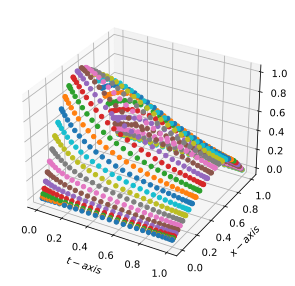

In [10]:
'''
    plotting the numerical solution obtained
'''
%config InlineBackend.figure_formats = ['svg']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(1, N + 1):
    for j in range(1, M + 1):
        ax.scatter(t[i], x[j], u_num[i,j])
        
ax.set_xlabel('$t-axis$')
ax.set_ylabel('$x-axis$')
ax.set_zlabel('u')

plt.show()

<div style="background: #E2FFCC;
            font-family: Bookerly;
            font-size: 16px; 
            font-weight: 100;
            padding: 10px 5px 10px 5px; 
            border: 10px solid #E2FFCC; 
            margin-left: 1px;
            margin-right: 1px;"

<font color='blue'>The Github repository of RyleighAMoore has a number of examples of differential quadrature scripts, including the one below, entitled 'EXAMPLE_FourHill.py'. 

In order to import locally devised Python Modules into Jupyter notebooks, there are several strategies. One goes like this. First it is necessary to make sure the working directory of the notebook is in the system path, which can be done as shown in the cell below.  Also, it is necessary to place the import targets -- files and folders -- in the working directory of the notebook itself. For the particular problem here presented, the list of required items is provided in the cell immediately following the plot.


</font>                 
</div>

In [4]:
import sys
#print(sys.path)
sys.path.append('C:\\Users\\gary')


Length of mesh =  287

 0.0 % Used Alternative Method**************

 0.0 % Reused Leja Points
Length of mesh =  287

 0.0 % Used Alternative Method**************

 12.543554006968641 % Reused Leja Points
Length of mesh =  287

 0.0 % Used Alternative Method**************

 51.91637630662021 % Reused Leja Points
Length of mesh =  287

 0.0 % Used Alternative Method**************

 63.41463414634146 % Reused Leja Points
Length of mesh =  287

 0.0 % Used Alternative Method**************

 75.60975609756098 % Reused Leja Points
Length of mesh =  287

 0.0 % Used Alternative Method**************

 75.9581881533101 % Reused Leja Points
Length of mesh =  287

 0.0 % Used Alternative Method**************

 85.71428571428571 % Reused Leja Points
Length of mesh =  315

 0.0 % Used Alternative Method**************

 81.58730158730158 % Reused Leja Points
Length of mesh =  345

 0.0 % Used Alternative Method**************

 77.39130434782608 % Reused Leja Points
Length of mesh =  370

 0.0 % Use

Length of mesh =  2671

 1.3103706476974917 % Used Alternative Method**************

 79.97004867090978 % Reused Leja Points
Length of mesh =  2709

 1.2919896640826873 % Used Alternative Method**************

 80.10335917312662 % Reused Leja Points
Length of mesh =  2765

 1.2658227848101267 % Used Alternative Method**************

 79.85533453887884 % Reused Leja Points
Length of mesh =  2801

 1.1424491253123885 % Used Alternative Method**************

 80.5783648696894 % Reused Leja Points
Length of mesh =  2851

 1.1574886004910558 % Used Alternative Method**************

 79.90178884601895 % Reused Leja Points
Length of mesh =  2899

 1.1383235598482235 % Used Alternative Method**************

 80.61400482925146 % Reused Leja Points
Length of mesh =  2949

 1.0851135978297728 % Used Alternative Method**************

 79.85757884028484 % Reused Leja Points
Length of mesh =  2743

 1.5311702515493983 % Used Alternative Method**************

 78.19905213270142 % Reused Leja Points
L

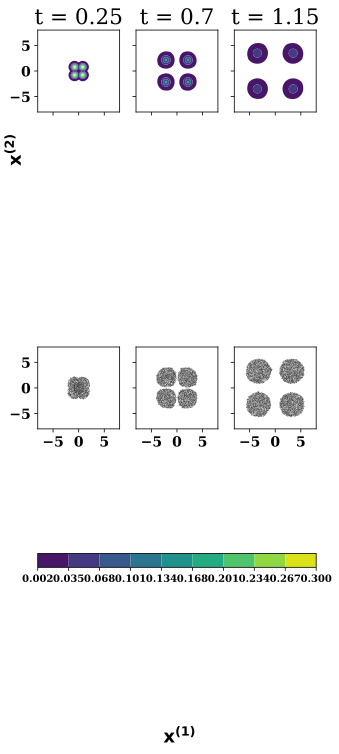

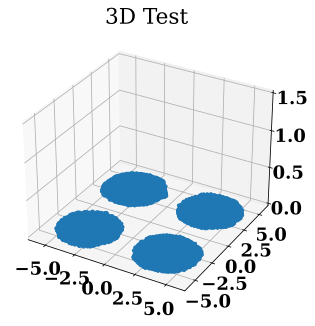

In [16]:
from DTQAdaptive import DTQ
import numpy as np
from DriftDiffFunctionBank import FourHillDrift, DiagDiffptSevenFive
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
plt.rcParams["figure.figsize"]=5,15
%config InlineBackend.figure_formats = ['svg']

mydrift = FourHillDrift
mydiff = DiagDiffptSevenFive

'''Initialization Parameters'''
NumSteps = 115
'''Discretization Parameters'''
a = 1
h=0.01
#kstepMin = np.round(min(0.15, 0.144*mydiff(np.asarray([0,0]))[0,0]+0.0056),2)
kstepMin = 0.12 # lambda
kstepMax = 0.14 # Lambda
beta = 3
radius = 1 # R
SpatialDiff = False

Meshes, PdfTraj, LPReuseArr, AltMethod= DTQ(NumSteps, kstepMin, kstepMax, \
                            h, beta, radius, mydrift, mydiff, SpatialDiff, PrintStuff=True)

pc = []
for i in range(len(Meshes)-1):
    l = len(Meshes[i])
    pc.append(LPReuseArr[i]/l)
    
mean = np.mean(pc)
#print("Leja Reuse: ", mean*100, "%")

pc = []
for i in range(len(Meshes)-1):
    l = len(Meshes[i])
    pc.append(AltMethod[i]/l)
    
mean2 = np.mean(pc)
#print("Alt Method: ", mean2*100, "%")


from plots import plotErrors, plotRowThreePlots, plot2DColorPlot, plotRowThreePlotsMesh, plotRowSixPlots
'''Plot 3 Subplots'''
# plotRowThreePlots(Meshes, PdfTraj, h, [24,69,114], includeMeshPoints=False)

# plotRowThreePlotsMesh(Meshes, PdfTraj, h, [24,69,114], includeMeshPoints=True)
plotRowSixPlots(Meshes, PdfTraj, h, [24,69,114])

# plot2DColorPlot(-1, Meshes, PdfTraj)


def update_graph(num):
    graph.set_data (Meshes[num][:,0], Meshes[num][:,1])
    graph.set_3d_properties(PdfTraj[num])
    title.set_text('3D Test, time={}'.format(num))
    return title, graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')
    
graph, = ax.plot(Meshes[-1][:,0], Meshes[-1][:,1], PdfTraj[-1], linestyle="", marker=".")
ax.set_zlim(0, 1.5)
ani = animation.FuncAnimation(fig, update_graph, frames=len(PdfTraj), interval=100, blit=False)
plt.show()

